# EMPIRICAL MACROECONOMICS
Francesco Franco, Nova SBE
## Non-fundamental Shocks: Replication of Ben S. Bernanke, Jean Boivin and Piotr Eliasz QJE 2005
**Measuring the Effects of Monetary Policy: A Factor-Augmented Vector Autoregressive(FAVAR) Approach. The Quarterly Journal of Economics, Vol. 120, No. 1 (Feb., 2005), pp. 387-422**

Refer to paper and class notes. Notation try to be consistent with paper.

# PART 1

In [3]:
'''Importing packages and functions''' 

import os                                # operating system
import pandas as pd                      # pandas
import numpy as np                       # numpy
from numpy import linalg as LA
from numpy.linalg import inv, multi_dot  # linear algebra from numpy for PCA
import matplotlib.pyplot as plt          # figures
%matplotlib inline                       

In [4]:
'''Load data set'''

df = pd.read_csv("nsbalpanel.csv",header=None)       #load data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Columns: 120 entries, 0 to 119
dtypes: float64(120)
memory usage: 479.2 KB


,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,0.01340,0.00861,0.00732,0.00523,0.00952,0.0133,0.01880,0.03120,0.04500,0.01740,...,0.00473,0.00000,0.00000,0.00436,0.00000,0.00000,0.00000,0.00348,0.00462,95.8
1,0.00602,0.00492,0.00000,0.01940,-0.00475,0.0107,0.01390,0.02560,0.03870,0.01490,...,0.00471,-0.00301,0.00524,0.00000,0.00000,0.00000,0.00000,-0.00348,0.00917,96.4
2,0.01430,0.01450,0.01570,0.00640,0.01650,0.0258,0.01600,0.02730,0.02970,0.03050,...,0.00000,0.00000,0.00000,0.00434,0.00345,0.00000,0.00000,0.00694,0.00456,96.9
3,0.00829,0.00956,0.00476,0.02010,0.00000,0.0319,0.00564,0.02540,0.03410,0.00892,...,0.00468,0.00301,0.00261,0.00432,0.00344,0.00000,0.00000,0.00690,0.00000,97.5
4,0.00704,0.00714,-0.00476,0.00746,-0.00703,0.0233,0.00337,-0.00659,-0.00736,-0.00301,...,0.00466,0.00000,0.00000,0.00000,0.00343,0.00325,0.00337,0.00343,0.00454,97.2


In [5]:
'''
   Data Description in Appendix1 page 416-420
   The transformation codes are:
   1:no transformation
   2:first difference
   4:logarithm
   5:first difference of logarithm.
   An asterisk *, next to the mnemonic, denotes a variable assumed to be slow-moving in the estimation
'''

# let us keep the indexes of the slow-moving variables

slowvars  = list(range(0,53))+list(range(102,119))   # remember that index in python starts with 0, therefore
                                                     # need to take out 1 from numbers in appendix
                                                     # furthermore range is closed on the left and open on the right
        
# let us keep the indexes of the variables for which they compute IRFs

xvars     = [15,106,76,79,90,91,94,73,100,16,48,23,45,53,61,66,117,118]
             
var_names = ['IP','CPI','3m TREASURY BILLS','5y TREASURY BONDS','M1','M2','MONETARY BASE',
             'EXCHANGE RATE YEN','COMMODITY PRICE INDEX','CAPACITY UTIL RATE',
            'PERSONAL CONSUMPTION','EMPLOYMENT','AVG WEEKLY HOURS',             
            'HOUSING STARTS','NEW ORDERS','S&Ps COMPOSITE','AVG HOURLY EARNINGS',
            'CONSUMER EXPECTATIONS']

In [6]:
'''Transforming the data'''

stdffr = df.loc[:,76].std()  # keep std of the ffr
df     = df.apply(lambda x: (x-x.mean())/x.std())

Consider the case where you observe one factor without error $Y_t=ffr_t$
$$\mathcal{X}_{t}=\Lambda\left[\begin{array}{c}
Y_{t}\\
F_{t}
\end{array}\right]+\left[\begin{array}{c}
0\\
e_{t}
\end{array}\right]$$

In [7]:
'''Specification: what is observable'''
# a couple of alternatives
df_np = df.values
Y = df_np[:,76]
X = np.delete(df_np,76,1)

In [8]:
Y =np.expand_dims(Y, axis=1)

In [9]:
''' Parameters '''

num_factors = 3                 # Change to increase number of factors to be extracted
N           = X.shape[1]        # number of series 
T           = X.shape[0]        # number of observations
M           = Y.shape[1]        # number of series considered observables factors
K           = num_factors
# number of periods for IRFS 
num_impulses = 40
num_lags     = 13
iter1        = 1
iter2        = 100


## PCA computing the eigenvalues and eigenvectors
This is the Linear Algebra algorithm that is widely used because numerically stable. In the notes we have that • The estimators of $F_{t}$ and $\Lambda$ solve the minimization problem$$\min_{\left\{ F_{t}\right\} _{t=1}^{T},\Lambda}\left(NT\right)^{-1}\sum_{t=1}^{T}\left[\mathcal{X}_{t}-\Lambda F_{t}\right]'\left[\mathcal{X}_{t}-\Lambda F_{t}\right]$$subject to $N^{-1}\Lambda'\Lambda=I_{r}.$

Under our simplified assumptions $\hat{F}_{t}=N^{-1}\hat{\Lambda}'\mathcal{X}_{t}$ and $\hat{\Lambda}$ is the matrix of eigenvectors (multiplied by $\sqrt{N}$) of the sample variance matrix of  $\mathcal{X}_{t}.$ 
Remember that a square matrix can be decomposed as $$\mathcal{X}'\mathcal{X}=VSV^{-1}$$ where $V$ are the eigenvectors and $S$ the eigenvalues. Now our covariance matrix is $$\frac{\mathcal{X}'\mathcal{X}}{N}$$ therefore $\Lambda=\sqrt{N}V$

#### Steps

1. Expand square
$$\min_{\left\{ F_{t}\right\} _{t=1}^{T},\Lambda}\left(NT\right)^{-1}\sum_{t=1}^{T}\left(\mathcal{X}_{t}'\mathcal{X}_{t}-\mathcal{X}_{t}'\Lambda F_{t}-F_{t}'\Lambda'\mathcal{X}_{t}-F_{t}'\Lambda'\Lambda F_{t}\right)-\lambda\left[N^{-1}\Lambda'\Lambda-I_{r}\right]$$

2. The gradient with respect to $F_{t}$ does not involve the constraint. 
Take the deriviative for every $t$ 

$$N^{-1}\left(\mathcal{X}_{t}'\mathcal{X}_{t}-2F_{t}'\Lambda'\mathcal{X}_{t}-F_{t}'\Lambda'\Lambda F_{t}\right)$$

and consider that $\mathcal{X}_{t}$ dimension is $N\times 1$, $F_{t}$ is $r\times1$ and $\Lambda$ is $N\times r$ so it is a scalar. Therefore you can apply the trace operator ans ude the following matrix calculus rules

$$\frac{\partial}{\partial F}Tr\left(F_{t}'\Lambda'\mathcal{X}_{t}\right)=\Lambda'\mathcal{X}_{t}$$

$$\frac{\partial}{\partial F}Tr\left(F_{t}'\Lambda'\Lambda F_{t}\right)=\Lambda'\Lambda F_{t}+\Lambda'\Lambda F_{t}$$

$$-N^{-1}(\Lambda'\Lambda F_{t}+\left(\Lambda'\Lambda\right)'F_{t})-N^{-1}2\Lambda'\mathcal{X}_{t}=0$$

$$F_{t}=(\Lambda'\Lambda)^{-1}\Lambda'\mathcal{X}_{t}$$

3. The gradient with rescpect to $\Lambda$ after concentrating out $F_{t}$ is equivalent in maximizing 

$$Tr(\Lambda'\mathcal{X}'\mathcal{X}\Lambda)-\lambda\left[N^{-1}\Lambda'\Lambda-I_{r}\right]$$

which gives 

$$\frac{\mathcal{X}'\mathcal{X}}{N}\Lambda=\Lambda S$$

## Detour on Principal Components


In [16]:
from sympy import diff, symbols, MatrixSymbol, Transpose, Trace, solve_linear_system, Matrix
 
def squared_norm(expr):
    return Trace(Transpose(expr)*expr)
 
N, q, n = symbols('N q n')
 
X = MatrixSymbol('X', N, 1)
Λ = MatrixSymbol('Λ', N, q)
F = MatrixSymbol('F', q, 1)
S = MatrixSymbol('S', N, q) 
print(diff(squared_norm(X-Λ*F), F))

-2*Λ.T*(X - Λ*F)


In [10]:
from numpy import linalg as LA

In [20]:
# Create two time series of 15 obserbations by using a dictionary and then feed it in a dataframe
Data = {'x1':[10,10.4,9.7,9.7,11.7,11,8.7,9.5,10.1,9.6,10.5,9.2,11.3,10.1,8.5],
        'x2':[10.7,9.8,10,10.1,11.5,10.8,8.8,9.3,9.4,9.6,10.4,9,11.6,9.8,9.2]}
X    = pd.DataFrame(Data)

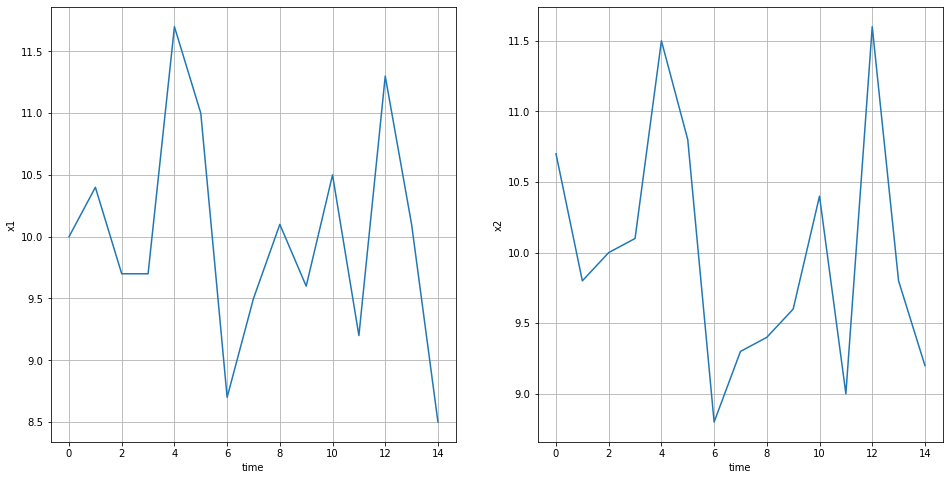

In [21]:
#Let us visualize the data, they are on purpose very related

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.xlabel('time')
plt.ylabel('x1')
plt.grid()
plt.plot(Data['x1'])

plt.subplot(122)
plt.xlabel('time')
plt.ylabel('x2')
plt.grid()
plt.plot(Data['x2'])

plt.show()

In [22]:
def extract_eig(x,nf):
    '''
    Compute the factors with the eigenvalues eigenvectors decomposition
    Inputs:  x the data
             nf number of factors
    Outputs: lam the factor loadings
             fac the factors  
    '''
    x = np.array(x)
    xx = x.T@x 
    s, V = LA.eig(xx)
    W = V[:,:nf]
    lam = W*np.sqrt(x.shape[1])
    fac = x@lam/x.shape[1]
    return fac, lam 

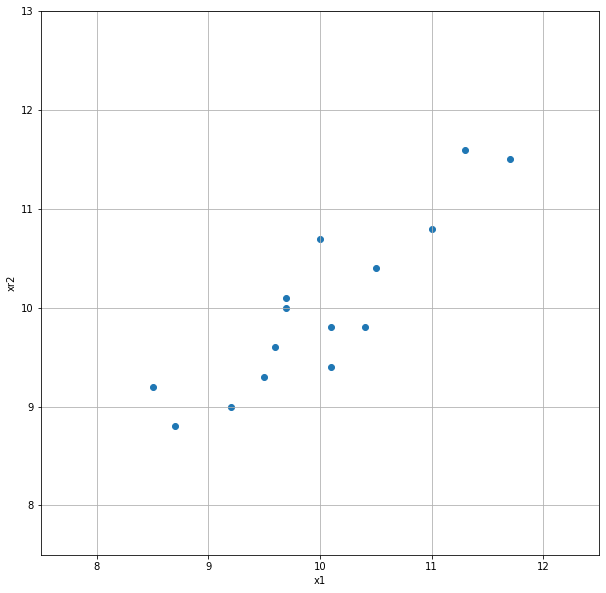

In [23]:
# Let us plot the scatter plot which gives us a different idea of the relationship between the two series
plt.figure(figsize=(10,10))
plt.xlabel('x1')
plt.ylabel('xr2')
plt.grid()
plt.ylim([7.5,13])
plt.xlim([7.5,12.5])

plt.scatter(Data['x1'],Data['x2'])
plt.show()

## Eigenvalues
A $p\times p$ symemtric, nonsingular matrix, such as the covariance matrix $XX$ may be reduced to a diagonal matrix $S$ by premultiplying and postmultiplying it by a particular orthonormal matrix $\Lambda$ such that $$\Lambda'\Omega\Lambda=S$$
The diagonal elements of $S$ are called the eigenvalues and the columns of $\Lambda$ are called the eigenvectors (notice that usually $\Lambda$ is used to denote de eigenvalues matrix but here I switched notation to be consistent with the class notes) .
The eigenvalues may be obtained from the solution of the equation (the characteristic equation, where $|A|$ denotes the determinant of $A$): $$|\Omega-sI|=0$$

In [24]:
X.cov()

,x1,x2
x1,0.798571,0.679286
x2,0.679286,0.734286


In [25]:
Ω = Matrix([[X.cov().iloc[0,0],X.cov().iloc[0,1]],
           [X.cov().iloc[1,0],X.cov().iloc[1,1]]])


The eigenvalues $s_1$ and $s_2$ by solving the characteristic equation $$|\Omega-sI|=\begin{vmatrix}\omega_{11}-s & \omega_{12}\\
\omega_{21} & \omega_{22}-s
\end{vmatrix}=\left(\omega_{11}-s\right)\left(\omega_{22}-s\right)-\omega_{21}\omega_{12}=0$$

In [26]:
Ω.charpoly()

PurePoly(1.0*lambda**2 - 1.53285714285714*lambda + 0.124950510204081, lambda, domain='RR')

In [27]:
Ω.eigenvals()

{1.44647433819575: 1, 0.0863828046613930: 1}

## Eigenvectors
Now you can find the eigenvectors as follows: find (unnormalized eigenvector)  $t_1$ associated to $s_1$ solves the following equation $$[\omega -s_1I]t_1=0$$ 
Which using our matrices is $$\left[\Omega-s_{1}I\right]t_{1}=\begin{bmatrix}\omega_{11}-s_{1} & \omega_{12}\\
\omega_{21} & \omega_{22}-s_{1}
\end{bmatrix}\begin{bmatrix}t_{11}\\
t_{21}
\end{bmatrix}=0$$ which gives two equations  $$t_{11}\left(\omega_{11}-s_{1}\right)+\omega_{12}t_{21}=0$$$$t_{11}\omega_{21}+t_{21}\left(\omega_{22}-s_{1}\right)=0$$
 

To solve normalize $t_{11}=1$ and solve using the first equation $t_{21}$. Finally plug the vector $t_1$ into the normalizing equation to obtain the eigenvector To solve normalize $t_{11}=1$ and solve using the first equation $t_{21}$. Finally plug the vector $t_1$ into the normalizing equation to obtain the eigenvector $\lambda_1$: $$\lambda_{1}=\frac{t_{1}}{\sqrt{t_{1}'t_{1}}}$$

In [29]:
Ω.eigenvects()

[(1.44647433819575,
  1,
  [Matrix([
   [0.723624808304448],
   [0.690193550249748]])]),
 (0.0863828046613930,
  1,
  [Matrix([
   [-0.690193550249748],
   [ 0.723624808304448]])])]

In [30]:
Λ = Matrix([[Ω.eigenvects()[0][2][0][0],Ω.eigenvects()[0][2][0][1]],
            [Ω.eigenvects()[1][2][0][0],Ω.eigenvects()[1][2][0][1]]])

Verify that $\Lambda'\Omega\Lambda=S$

In [31]:
Λ@Ω@Λ.T

Matrix([
[     1.44647433819575, 1.11022302462516e-16],
[-6.93889390390723e-18,   0.0863828046613931]])

# Interpretation
you are changing the axis coordinates of the point from the blue axis to the red axis. Notice that the first eigenvector (the red axis with the thicker arrow, the thickness is here the value of the eigenvalue) corresponds to the axis that explain the most the data 

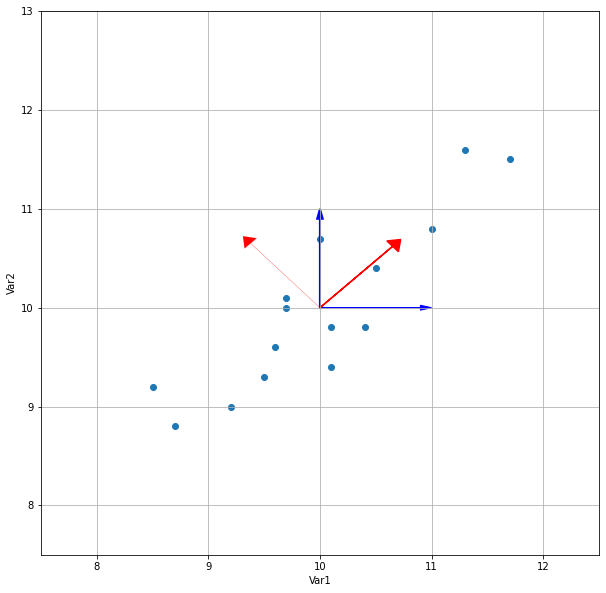

In [32]:
S = Λ@Ω@Λ.T

# Notice that in this graph in the new axis coordinates
# you need to feed the values of the eigenvalues s and the eigenvectors V
plt.figure(figsize=(10,10))
plt.xlabel('Var1')
plt.ylabel('Var2')
plt.grid()
plt.ylim([7.5,13])
plt.xlim([7.5,12.5])

#old axis coordinates
plt.arrow(10, 10, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1,linewidth=2,color='b')
plt.arrow(10, 10, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, color='b',linewidth=1)

#new axis coordinates
plt.arrow(10, 10, 0.723624808304448, 0.690193550249748, head_width=0.15, length_includes_head=True, head_length=0.1, color='r',linewidth=S[0,0])
plt.arrow(10, 10, -0.690193550249748, 0.723624808304448, head_width=0.15, length_includes_head=True, head_length=0.1, color='r',linewidth=S[1,1])

plt.scatter(Data['x1'],Data['x2'])
plt.show()

Compute the factors $F_t = \Lambda X_t$ and plot them

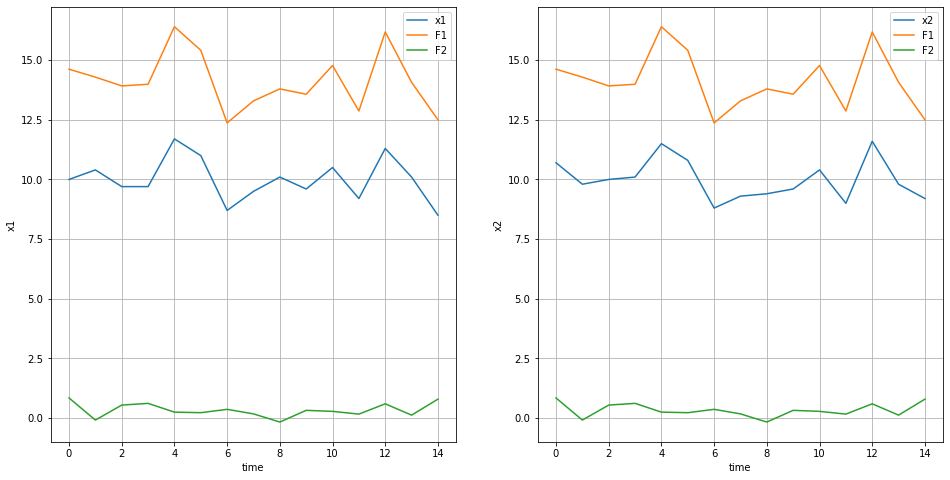

In [33]:
F = Λ@np.array(X.T)

#Let us visualize the data, they are on purpose very related

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.xlabel('time')
plt.ylabel('x1')
plt.grid()
plt.plot(Data['x1'])
plt.plot(np.array(F.T))
plt.legend(['x1','F1','F2'])
plt.subplot(122)
plt.xlabel('time')
plt.ylabel('x2')
plt.grid()
plt.plot(Data['x2'])
plt.plot(np.array(F.T))
plt.legend(['x2','F1','F2'])
plt.show()

## PCA using the SVD decomposition
The SVD decomposition is practical because always exists and says that $\mathcal{X}=VSU'$ where $V$ and $U$ are orthonormals. Therefore $$\mathcal{X}'\mathcal{X}=VSU'USV'=VS^{2}V'$$ and we can see that $V$ is our $\Lambda$ (divided by  $\sqrt{N}$).

In [10]:
def extract_svd(x,nf):
    '''
    Compute the factors with SVD
    Inputs:  x the data
             nf number of factors
    Outputs: lam the factor loadings
             fac the factors  
    '''     
    x = np.array(x)
    U, s , V = LA.svd(x)
    W = V.T[:,:nf]
    lam = W*np.sqrt(x.shape[1])
    fac = x@lam/x.shape[1]    
    return fac, lam 

## Slow-R-Fast identification scheme
the Bernanke, Boivin, and Eliasz (2005) implementation of the slow-R-fast identification scheme starts from 
$$\mathcal{X}_{t}=\Lambda F_{t}+e_{t}$$
and divide the factors into slow-moving and fast-moving
$$\begin{bmatrix}\mathcal{X}_{t}^{s}\\
\mathcal{X}_{t}^{f}
\end{bmatrix}=\begin{bmatrix}\Lambda_{ss} & 0 & 0\\
\Lambda_{fs} & \Lambda_{fr} & \Lambda_{ff}
\end{bmatrix}\begin{bmatrix}F_{t}^{s}\\
R_{t}\\
F_{t}^{f}
\end{bmatrix}+e_{t}$$
or $$\mathcal{X}_{t}^{s}=\Lambda_{ss}F_{t}^{s}+e_{t}^{s}$$ $$\mathcal{X}_{t}^{f}=\Lambda_{fs}F_{t}^{s}+\Lambda_{fr}R_{t}+\Lambda_{ff}F_{t}^{f}+e_{t}^{f}$$
And
$$\begin{bmatrix}F_{t}^{s}\\
R_{t}\\
F_{t}^{f}
\end{bmatrix}=\Phi(L)\begin{bmatrix}F_{t-1}^{s}\\
R_{t-1}\\
F_{t-1}^{f}
\end{bmatrix}+\begin{bmatrix}\eta_{t}^{s}\\
\eta_{t}^{r}\\
\eta_{t}^{f}
\end{bmatrix}$$

In the paper (p.405) they decribe the following procedure:
- get $F_{t}$ from the $\mathcal{X}_{t}$ whole dataset.
- get $F_{t}^{s}$ from the $\mathcal{X}_{t}^{s}$ sub-dataset.
- regress $F_{t}=\beta_{s}F_{t}^{s}+\beta_{r}R_{t}+u_{t}$
- $F_{t}^{r}=F_{t}-\hat{\beta}_{r}R_{t}$

In [11]:
def cleanfac(F,pol,Fs):
    '''
    computes the factors as described in p.405 of the paper
    Inputs:  F:   Unrestricted PC estimates (from all the dataset)
             pol: policy instrument
             Fs:  Proxy of the slow moving factors
    Outputs: Fr: factors cleaned from pol
    '''
    F, Fs, pol = np.array(F),np.array(Fs),np.array(pol)
    Fs = np.hstack([Fs, pol])
    betas = LA.inv(Fs.T@Fs)@Fs.T@F
    Fr = F - np.dot(pol,betas[num_factors:,:])
    #Fr = pd.DataFrame(Fr)
    
    return Fr

In [12]:
'''
Extract factors and clean them from observables effects
''' 
F, LAMBDA = extract_svd(X,K)
xs = df.loc[:,df.columns[slowvars]]
Fs,LAMBDAs = extract_svd(xs,K)
Fr = cleanfac(F,Y,Fs)
et = X-F@LAMBDA.T  # keep the residuals

We estimate the VAR $$X_{t}=B(1)X_{t-1}+B(2)X_{t-2}+...+\eta_{t}$$ then invert to obtain the IRF:$$X_{t}	=C(L)^{-1}\eta_{t}$$ or
$$X_{t}	=\eta_{t}+C(1)\eta_{t-1}+...$$ and identify the strucrural shocks : $$X_{t}	=A(0)\epsilon_{t}+C(1)A(0)\epsilon_{t-1}+...$$
Using

$$
\begin{bmatrix}\eta_{t}^{s}\\
\eta_{t}^{r}\\
\eta_{t}^{f}
\end{bmatrix}=\begin{bmatrix}1 & 0 & 0\\
A_{rs} & 1 & 0\\
A_{fs} & A_{fr} & 1
\end{bmatrix}\begin{bmatrix}\epsilon_{t}^{s}\\
\epsilon_{t}^{r}\\
\epsilon_{t}^{f}
\end{bmatrix}$$

This short run identification is implemented using the Choleski decomposition:

here $$\hat{\eta}'\hat{\eta} = \hat{\Omega} = A(0)'\epsilon\epsilon A(0)$$

Now use $\epsilon\epsilon = \left[\begin{array}{ccc}
\sigma_{1}^{2} & 0 & 0\\
0 & \sigma_{2}^{2} & 0\\
0 & 0 & \sigma_{fed}^{2}
\end{array}\right]$

and use the Cholesky  decomposition. For every symetric matrix  $A(0) = LL'$
where $L$ is lower triangular. We then transform the lower triangular matrix
in a matrix with ones on the diagonal by dividing by the diagional of $L$.

### Let us construct a Class like we did for BQ paper
Basically we are combining all the steps we did above

In [13]:
'''
We can build our own VAR Class for the Short Run Identification
And we have options in how to program it
here with numpy
'''
class VAR_np_class2():
    
    def __init__(self,X,xsub,lags,shock,num_impulses=40):
        
        self.X = X
        self.xsub = xsub
        self.lags = lags
        self.num_vars = X.shape[1]
        self.num_obs = X.shape[0] - self.lags
        self.num_impulses = num_impulses
        self.shock = shock
        
    def XLAGp(self):       
        XLAG = np.vstack((np.empty((1,4)),self.X[0:-1,:]))
        for i in range(2,self.lags+1):
            tmp1 = np.vstack((np.empty((i,4)),self.X[0:-i,:]))
            XLAG = np.hstack((XLAG,tmp1))
        X2 = self.X[self.lags:,:]
        XLAG2 = XLAG[self.lags:,:]
        return X2, XLAG2
    
    def fit(self):
        X2, XLAG2 = self.XLAGp()
        Bhat = inv(XLAG2.T@XLAG2)@XLAG2.T@X2
        c_Bhat = np.vstack((Bhat.T,np.hstack((np.identity((self.lags-1)*self.num_vars),
                                              np.zeros([(self.lags-1)*self.num_vars,self.num_vars]))))) 
       
        return Bhat, c_Bhat
    
    def IRF(self):
        IRF  = np.zeros([self.num_impulses,self.num_vars,self.num_vars])
        
        Bhat,c_Bhat = self.fit()
        X2, XLAG2 = self.XLAGp()
        EPS = (X2 - XLAG2@Bhat)
        #estimated covariance matrix
        Omegahat = EPS.T@EPS/(self.num_obs - self.lags*self.num_vars - 1)      
        #Setting up for SR restriction
        A0 = LA.cholesky(Omegahat)
        d = np.zeros(A0.shape)
        np.fill_diagonal(d,np.diag(A0))
        A0 = np.dot(np.linalg.inv(d),A0)
        F = inv(A0)
        ETA = EPS@F.T
        psi  = []
        Temp = np.identity(c_Bhat.shape[0])
        for t in range(self.num_impulses):
            psi_t = Temp[:self.num_vars,:self.num_vars] 
            IRF[t,:,:] = psi_t@A0         # store the IRF
            Temp = c_Bhat@Temp            # computes the exponent of the matrix
            #psi.append(psi_t)            # stores the matrices Psi (notations as in Hamilton)

        
        IRF   = IRF@self.shock 
        
        irf  = pd.DataFrame({i:IRF[i].flatten() for i in range(num_impulses)}).T #save IRFs into dataframe
        #irf.columns = ["s_y","d_y","s_u","d_u"]
        irf_cum = irf.cumsum() #output is expressed cumulatively
        # xsub is the subset of X that they study in the paper
        
        bx   = LA.inv(self.X.T@self.X)@self.X.T@self.xsub
        irf_sub = irf@bx
        return A0,EPS,ETA,irf,irf_cum,irf_sub       

In [14]:
'''
Prepare the data
'''
Xvar = np.hstack((Fr,Y))
xsub = X[:,xvars]
# Shock
shock = np.hstack([np.zeros([1,K+M-1]), np.ones([1,1])*0.25/stdffr])
shock = shock.T

In [15]:
prova = VAR_np_class2(Xvar,xsub,13,shock)

In [16]:
A0,EPS,ETA,irf,irf_cum,irf_sub = prova.IRF()

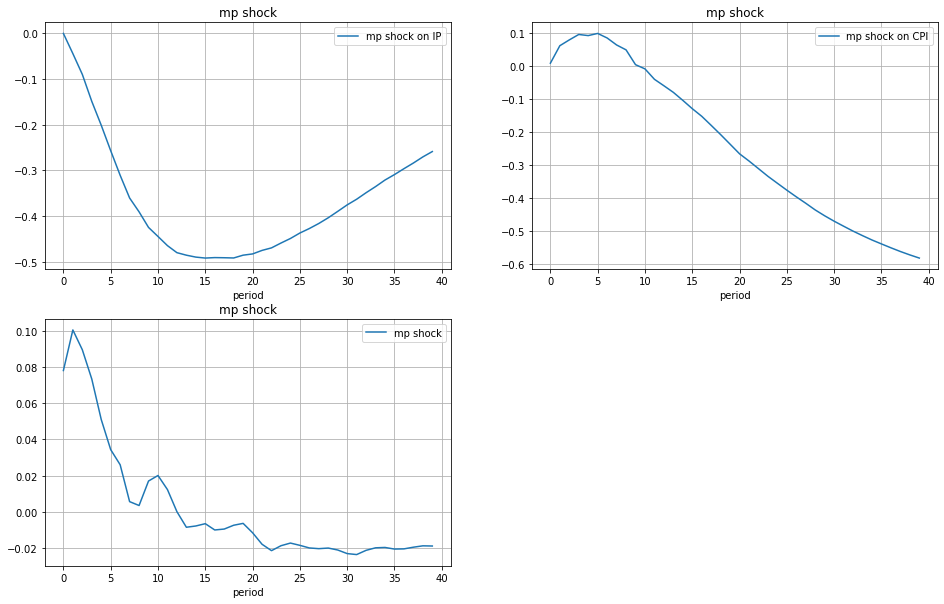

In [17]:
# Plot the IRFs

plt.figure(figsize=(16,10))

plt.subplot(221)
plt.plot(np.exp(np.cumsum(irf_sub[0]))-1,label='mp shock on IP')
plt.legend()
plt.xlabel('period')
plt.title('mp shock')
plt.grid()

plt.subplot(222)
plt.plot(np.exp(np.cumsum(irf_sub[1]))-1,label='mp shock on CPI')
plt.legend()
plt.xlabel('period')
plt.title('mp shock')
plt.grid()

plt.subplot(223)
plt.plot(irf[3],label='mp shock')
plt.legend()
plt.xlabel('period')
plt.title('mp shock')
plt.grid()

# PART II

Bootstrapping the IRF

The issue can be understood as follows. When we estimate the VAR $$X_{t}=B(1)X_{t-1}+B(2)X_{t-2}+...+v_{t}$$ then invert to obtain the IRF:$$X_{t}	=C(L)^{-1}v_{t}$$ or
$$X_{t}	=v_{t}+C(1)v_{t-1}+...$$ or on the strucrural shocks : $$X_{t}	=A(0)\epsilon_{t}+C(1)A(0)\epsilon_{t-1}+...$$
we are :
- estimtating $B(L)$ with OLS, therefore subject to small sample bias (on top of the issues due to autocorelation not handled well), same for the covariance of the innovations (reduced form residuals)
- obtain the IRF from the non linear transformation of the $B(L)$ and of the covariance
.This can result in substantially biased IRF.

# Bootstrapping
Loop2 is nested in Loop1. Denote by $it_1=N_1$ a replication of loop 1
1. Loop1: Reshuffle $e_t$ and obtain $e_t^*$

    Compute $$\mathcal{X_{t}^{it_1}}=\hat{\Lambda} F_{t}+e_{t}^*$$

    Use the function extract factors to get $F_{t}^{r,it}=F_{t}^{it_1}-\hat{\beta^{it}}_{r}R_{t}$
    
    
2. Loop2: Reshuffle $v_t$ and obtain $v_t^*$. Here scale the redisuals.
    
    Estimate the VAR(p) and generate $it_2=N_2$ bootstrap replications of $\hat{B^{it_2}}$ from
    
    $$X^{it_2}_{t}=\hat{B}(1)X^{it_2}_{t-1}+\hat{B}(2)X^{it_2}_{t-2}+...+v^{it_2}_{t}$$
    
    Identify $A(0)^{it_2}$
    
    Compute the IRFs $$\hat{X}_{t+s}^{it_2}=\sum_{i=0}^{s-1}C_{i}^{it_2}A(0)^{it_2}\eta_{t+s-i}^{it_2}$$
    
3. Sort the $it_1*it_2$ and IRFs keep the 5,and 95 percintile 

In [18]:
def extract_fac(x,Y,K,slowvars):
    '''
    Routine to extract the factors
    1. Extract factors from whole dataset F
    2. Extract factors from slow moving dataset Fslow
    3. Regress factors F on Flsow and Y and subtract effect of Y from F to obtain Fr
    '''
    x =  pd.DataFrame(x)
    xs = x.loc[:,x.columns[slowvars]]
    F,Lf = extract_svd(x,K)
    Fs , Lfs = extract_svd(xs,K)
    Fr = cleanfac(F,Y,Fs)    
    return Fr

## Inner Loop 

As a first step just look at CI with uncertainty on VAR estimates

In [25]:
'''
Bootstrap of the confidence intervals
This firt example only consider Loop2
'''

iter2 = 100
num_vars = M+K
num_obs = Xvar.shape[0] - 13
#Containers for IRF
IRF_var = np.zeros([num_impulses*(M+K),iter2])
IRF_xsub = np.zeros([num_impulses*xsub.shape[1],iter2])
# Start
bx   = LA.inv(Xvar.T@Xvar)@Xvar.T@xsub
ex   = xsub - Xvar@bx
ex_r = ex.copy()
prova = VAR_np_class2(Xvar,xsub,13,shock)
Bhat,c_Bhat = prova.fit()
A0,EPS,ETA,irf,irf_cum,irf_sub = prova.IRF()
G0_hat = np.vstack((np.eye(num_vars),np.zeros([(num_lags-1)*num_vars,num_vars])))
scale = np.sqrt(num_obs/(num_obs - num_lags*num_vars))
EPS_r = scale*EPS.copy()
for it in range(iter2):
    
    np.random.shuffle(EPS_r)    
    X_r = np.zeros([num_vars,num_lags])
    X_init_r = Xvar.copy()
    np.random.shuffle(X_init_r)
    for i in range(num_lags):
        X_r[:,num_lags-i-1]=X_init_r[i,:]
    X_r = np.reshape(X_r,(num_lags*num_vars,1),order='F')
    X_r = np.hstack((X_r,np.zeros([num_lags*num_vars,num_obs-1])))        
    for t in range(num_obs-1):
        X_r[:,t+1] = np.dot(c_Bhat,X_r[:,t])+ np.dot(G0_hat,EPS_r.T[:,t])
    datasim = np.vstack((X_init_r[0:num_lags],X_r[0:4,:].T))    
   
    np.random.shuffle(ex_r)
    xsub_r = datasim@bx + ex_r      
    prova = VAR_np_class2(datasim,xsub_r,13,shock)
    A0_ci,EPS_ci,ETA_ci,irf_ci,irf_cum_ci,irf_sub_ci = prova.IRF()
    IRF_var[:,it]  = np.reshape(np.array(irf_ci),(num_impulses*(1+num_factors),1)).flatten()
    IRF_xsub[:,it] = np.reshape(np.array(irf_sub_ci),((num_impulses*len(xvars)),1)).flatten()

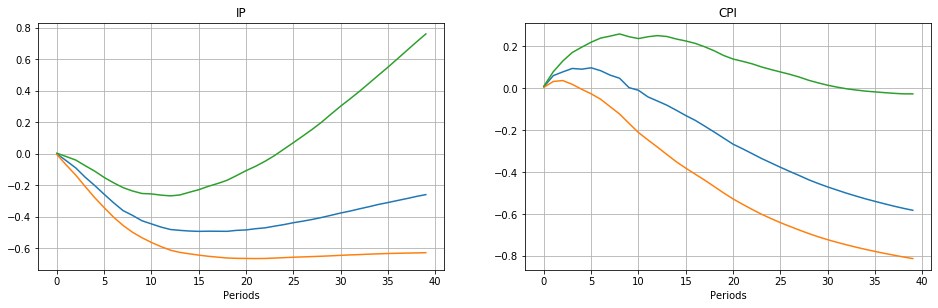

In [26]:
# KEEP THE 5% - 95% IRF sorted 
IRF_var        = IRF_var.reshape(num_impulses,M+K,iter1*iter2)
IRF_xsub       = IRF_xsub.reshape(num_impulses,len(xvars),iter1*iter2)
IRF_var        = np.sort(IRF_var,axis=2)
IRF_xsub       = np.sort(IRF_xsub,axis=2)
iter_tot       = iter1*iter2
IRF_varci      = IRF_var[:,:,[np.int(0.05*iter_tot),np.int(0.95*iter_tot)]]
IRF_xsubci     = IRF_xsub[:,:,[np.int(0.05*iter_tot),np.int(0.95*iter_tot)]]

# PLOT THE IRS WITH CI

plt.figure(figsize=(16,10))
plt.subplot(221)
plt.plot(np.exp(np.cumsum(irf_sub[0]))-1)
plt.plot(np.exp(np.cumsum(IRF_xsubci[:,0,0]))-1)
plt.plot(np.exp(np.cumsum(IRF_xsubci[:,0,1]))-1)
plt.xlabel('Periods')
plt.title('IP')
plt.grid()
plt.subplot(222)
plt.plot(np.exp(np.cumsum(irf_sub[1]))-1)
plt.plot(np.exp(np.cumsum(IRF_xsubci[:,1,0]))-1)
plt.plot(np.exp(np.cumsum(IRF_xsubci[:,1,1]))-1)
plt.xlabel('Periods')
plt.title('CPI')
plt.grid()


## Outer and Inner loops

Lets us now have the two loops (careful on the number of replications)

In [28]:
'''
Bootstrap of the confidence intervals
This example consider Loop1 and Loop2
'''
iter1 = 10
iter2 = 100
num_vars = M+K
num_obs = Xvar.shape[0] - 13
IRF_var = np.zeros([num_impulses*(M+K),iter1*iter2])
IRF_xsub = np.zeros([num_impulses*xsub.shape[1],iter1*iter2])

bx   = LA.inv(Xvar.T@Xvar)@Xvar.T@xsub
ex   = xsub - Xvar@bx
ex_r = ex.copy()
prova = VAR_np_class2(Xvar,xsub,13,shock)
A0,EPS,ETA,irf,irf_cum,irf_sub = prova.IRF()
G0_hat = np.vstack((np.eye(num_vars),np.zeros([(num_lags-1)*num_vars,num_vars])))
scale = np.sqrt(num_obs/(num_obs - num_lags*num_vars))
EPS_r = scale*EPS.copy()
et_rep = et.copy()
iteration=0
for rep in range(iter1):
    np.random.shuffle(et_rep)
    X_star = F@LAMBDA.T+ et_rep
    # get the factors from the new dataset
    Fr_star = extract_fac(X_star,Y,K,slowvars)
    Xvar_rep = np.hstack((Fr_star, Y))
    
    bx_rep = LA.inv(Xvar_rep.T@Xvar_rep)@Xvar_rep.T@xsub
    ex_rep = xsub - Xvar_rep@bx_rep
    
    prova_rep = VAR_np_class2(Xvar_rep,xsub,13,shock)
    Bhat_rep,c_Bhat_rep = prova_rep.fit()
    A0_rep,EPS_rep,ETA_rep,irf_rep,irf_rep_cum_rep,irf_sub_rep = prova_rep.IRF()
    EPS_r = scale*EPS_rep.copy()
    for it in range(iter2):
        iteration=iteration+1
    
        np.random.shuffle(EPS_r)    
        X_r = np.zeros([num_vars,num_lags])
        X_init_r = Xvar_rep.copy()
        np.random.shuffle(X_init_r)
        for i in range(num_lags):
            X_r[:,num_lags-i-1]=X_init_r[i,:]
        X_r = np.reshape(X_r,(num_lags*num_vars,1),order='F')
        X_r = np.hstack((X_r,np.zeros([num_lags*num_vars,num_obs-1])))        
        for t in range(num_obs-1):
            X_r[:,t+1] = np.dot(c_Bhat_rep,X_r[:,t])+ np.dot(G0_hat,EPS_r.T[:,t])
        datasim = np.vstack((X_init_r[0:num_lags],X_r[0:4,:].T))    
   
        np.random.shuffle(ex_rep)
        xsub_r = datasim@bx_rep + ex_rep      
        prova = VAR_np_class2(datasim,xsub_r,13,shock)
        A0_ci,EPS_ci,ETA_ci,irf_ci,irf_cum_ci,irf_sub_ci = prova.IRF()
        IRF_var[:,iteration-1]  = np.reshape(np.array(irf_ci),(num_impulses*(1+num_factors),1)).flatten()
        IRF_xsub[:,iteration-1] = np.reshape(np.array(irf_sub_ci),((num_impulses*len(xvars)),1)).flatten()

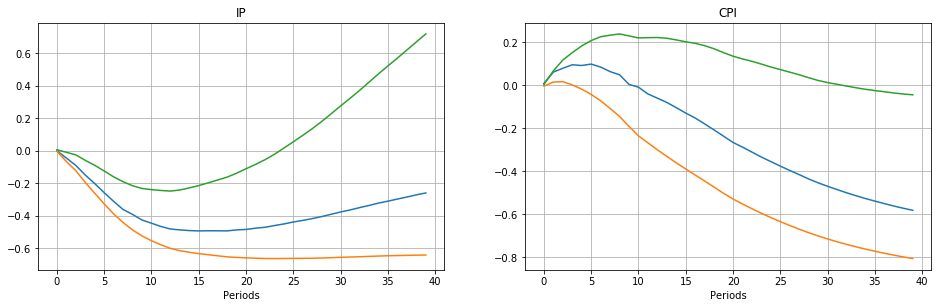

In [29]:
# KEEP THE 5% - 95% IRF sorted 
IRF_var        = IRF_var.reshape(num_impulses,M+K,iter1*iter2)
IRF_xsub       = IRF_xsub.reshape(num_impulses,len(xvars),iter1*iter2)
IRF_var        = np.sort(IRF_var,axis=2)
IRF_xsub       = np.sort(IRF_xsub,axis=2)
iter_tot       = iter1*iter2
IRF_varci      = IRF_var[:,:,[np.int(0.05*iter_tot),np.int(0.95*iter_tot)]]
IRF_xsubci     = IRF_xsub[:,:,[np.int(0.05*iter_tot),np.int(0.95*iter_tot)]]

# PLOT THE IRS WITH CI

plt.figure(figsize=(16,10))
plt.subplot(221)
plt.plot(np.exp(np.cumsum(irf_sub[0]))-1)
plt.plot(np.exp(np.cumsum(IRF_xsubci[:,0,0]))-1)
plt.plot(np.exp(np.cumsum(IRF_xsubci[:,0,1]))-1)
plt.xlabel('Periods')
plt.title('IP')
plt.grid()
plt.subplot(222)
plt.plot(np.exp(np.cumsum(irf_sub[1]))-1)
plt.plot(np.exp(np.cumsum(IRF_xsubci[:,1,0]))-1)
plt.plot(np.exp(np.cumsum(IRF_xsubci[:,1,1]))-1)
plt.xlabel('Periods')
plt.title('CPI')
plt.grid()



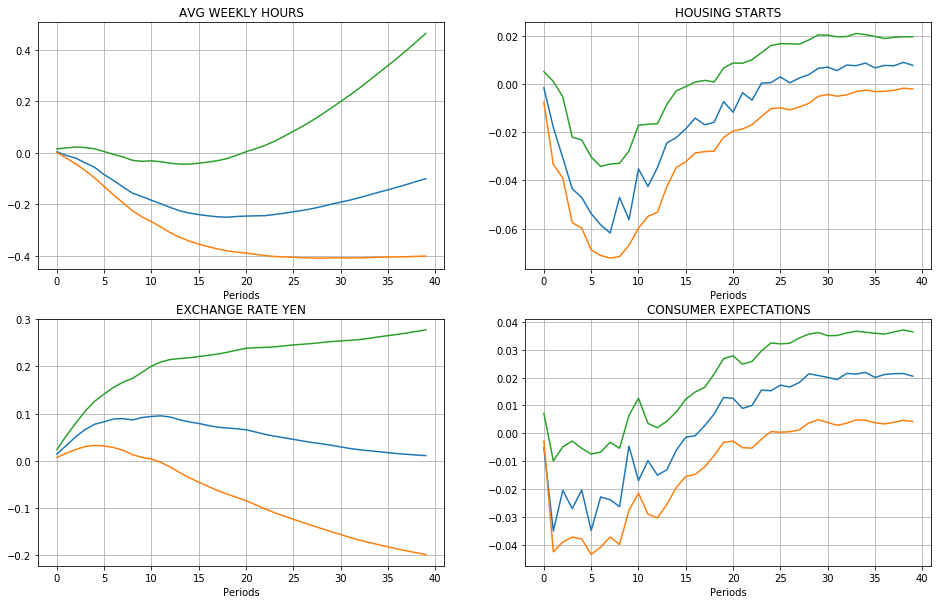

In [30]:
plt.figure(figsize=(16,10))
plt.subplot(221)
plt.plot(np.exp(np.cumsum(irf_sub[12]))-1)
plt.plot(np.exp(np.cumsum(IRF_xsubci[:,12,0]))-1)
plt.plot(np.exp(np.cumsum(IRF_xsubci[:,12,1]))-1)
plt.xlabel('Periods')
plt.title(var_names[12])
plt.grid()
plt.subplot(222)
plt.plot(np.exp(irf_sub[13])-1)
plt.plot(np.exp(IRF_xsubci[:,13,0])-1)
plt.plot(np.exp(IRF_xsubci[:,13,1])-1)
plt.xlabel('Periods')
plt.title(var_names[13])
plt.grid()
plt.subplot(223)
plt.plot(np.exp(np.cumsum(irf_sub[7]))-1)
plt.plot(np.exp(np.cumsum(IRF_xsubci[:,7,0]))-1)
plt.plot(np.exp(np.cumsum(IRF_xsubci[:,7,1]))-1)
plt.xlabel('Periods')
plt.title(var_names[7])
plt.grid()
plt.subplot(224)
plt.plot(irf_sub[17])
plt.plot(IRF_xsubci[:,17,0])
plt.plot(IRF_xsubci[:,17,1])
plt.xlabel('Periods')
plt.title(var_names[17])
plt.grid()